# Content description
This notebook contains main analysis of the project.<br>
## Content table:
### 1. Load data
### 2. Preprocessing
Contains fine-grained preprocessing relevant to our analysis.
### 3. Analysis:
  1. **Gender analysis** - 
  Analysis of the climate change related quotes with respect to the speaker's gender.
  2. **Age analysis** - 
  Analysis of the climate change related quotes with respect to the speaker's age group.
  3. **Educational analysis** - 
  Analysis of the climate change related quotes with respect to the speaker's educational level.
  4. **Analysis with respect to political party** - 
  Quantitative analysis of the climate change related quotes with respect to the speaker's political party. Major part of the analysis is performen only on relevant, Democratic and Republican party.
  5. **Sentiment and misinformation analysis** - 
  Qualitative analysis of the climate change related quotes with respect to the speaker's political party. Major part of the analysis is performen only on relevant, Democratic and Republican party.
  6. **Quantitative analysis on individual politicians** - 
  Quantitative analysis of the climate change related quotes with respect to the speaker.
  7. **Regression analysis** - 
  Summarizes which characteristics are the most important to our problem and our conclusions.
  8. **Timeline analysis** - Quantitative analysis with respect to individual speaker. Analysis emphasizes the time component of the quotations, i.e. when the quotation were said.

### 4. Helper functions
Contains helper functions used in the anaysis.

## Milestone 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.dates as mdates

from scipy.stats import ttest_ind

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1. Mount Drive

In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load data
Firstly we will load the data.


In [3]:
PREFIX  = '/content/drive/MyDrive/ADA_Resources/'
QUOTATION_PATH  = PREFIX + 'Enrichment/climate_change_quotes_small_v4_analysis.json'
SPEAKER_PATH = PREFIX + 'speakers/us_politicians_cleaned.json.bz2'
SPEAKER_COUNT = PREFIX + 'Extractor/speaker_date_count_renamed.csv'

In [ ]:
# Loading quotations data
df_quotes = pd.read_json(QUOTATION_PATH, lines= True)
df_quotes.head()

,quotation,speaker,qids,date,numOccurrences,urls,sentimentScores,cardsPredLabel,domains,total_num_quotes,totalNumOccurrences
0,"Because America is leading by example, 150 cou...",President Obama,Q76,2015-10-26,1,[http://catholic.org/news/politics/story.php?i...,-0.527811,0,[catholic],83105,358404
1,biggest driver of climate change.,President Barack Obama,Q76,2015-08-08,1,[http://www.theblaze.com/contributions/sweepin...,0.968509,0,[theblaze],83105,358404
2,Climate change is a fact. The debate is settled.,President Obama,Q76,2015-01-19,1,[http://thehill.com/policy/energy-environment/...,0.885463,0,[thehill],83105,358404
3,I welcome His Holiness Pope Francis's encyclic...,President Barack Obama,Q76,2015-06-18,36,[http://mashable.com/2015/06/18/pope-francis-c...,0.999841,0,"[mashable, yahoo, yahoo, dailyherald, go, dese...",83105,358404
4,Our climate is changing. It's changing in ways...,President Barack Obama,Q76,2015-08-02,8,[http://www.upi.com/Top_News/US/2015/08/02/Oba...,0.967505,0,"[upi, upi, upi, upi, upi, bignewsnetwork, upi,...",83105,358404


- **df_quotes**  <br> This Dataframe contains data related to climate change quotes extracted from preprocessed Quotebank database. Extraction has been performed using BERT model. For more details about initial preprocessing, refer to **'Quotebank_preprocessing'** notebook, while for more informations about extraction refer to **'Extraction_BERT'** notebook. <br>On every datapoint from this set has been applied (for more informations, refer to **'Enrichment'** notebook.):<br>
1. Sentiment analysis using **DBERT** (Distiled BERT for sentiment analysis, i.e. HuggingFace implementation) model. This is described in the column *'sentiment scores'*.
2. Misinformation detection using **CARDS** (Computer-assisted detection and classification of misinformation about climate change) model. This is described in the column *'cardsPredLabel'*
3. Extraction of domains using **tld** library. This is described in the column *'domains'* <br>
4. Extraction of total number of quotation in general for speaker <br> This is described in the column *total_num_quotes*.
Total number of quotation for speaker
5.Extraction fo total number of occurrences of quotations for speaker <br>
This is described in the column *totalNumOccurrences* 


In [ ]:
# Loading speakers data
df_speakers = pd.read_json(SPEAKER_PATH, lines=True, compression='bz2')


- **df_speakers**  <br>This DataFrame contains preprocessed data from initial *parquet* file, where only relevant US politicians have been preserved. For more info refer to **'Wikidata_preprocessing'** notebook.

In [5]:
# Loading data for timeline analysis
df_counts = pd.read_csv(SPEAKER_COUNT)
df_counts.head()

,qids,date,num_of_quotes
0,Q1001235,2015-03-01,1
1,Q1001235,2017-08-01,1
2,Q1001235,2018-12-01,1
3,Q1017083,2019-07-01,1
4,Q1018322,2015-03-01,1



- **df_counts** <br>This DataFrame contains data describing number of quotes said by speaker in different months. Note that it is chosen to count number of qutoes from the first day of observed month. For more informations refer to **'Enrichment'** notebook.

In [6]:
df_counts.date = pd.to_datetime(df_counts.date)
# Truncate hours, minutes and seconds
df_counts.date = df_counts.date.apply(lambda date: datetime.date(date.year, date.month, date.day))

#2. Preprocessing
Before we dive in with the analysis, we need to perform minor fine-grain preprocessing on our data. <br>
We will add additional features in **df_speakers** DataFrame, which will help us in our investigation: <br>
1. Gender column

In [ ]:
# Converting gender id to name
GENDER = {'Q2449503' : 'Transgender male',
          'Q1052281': 'Transgender female',
          'Q6581097' : 'Male',
          'Q6581072' : 'Female'}
df_speakers['gender_name'] = df_speakers.gender.apply(lambda gid: gid if gid is None else GENDER[gid])

2. Academic level (i.e. number of obtained diplomas)

In [ ]:
# Counting number of degrees, i.e. degree of education
df_speakers['degree_num'] = df_speakers.academic_degree.apply(lambda x: 0 if x is None else len(x))

3. Indicator if the politician has been part of the US congress

In [ ]:
# Extracting indicator 'was_in_congres'
df_speakers['was_in_congres'] = df_speakers.US_congress_bio_ID.notna()

4. Indicator if the politician has been presidential candidate in his career

In [ ]:
# Indicator of presidential candidate
df_speakers['was_candidate'] = df_speakers.candidacy.notna()

5. Indicator if the politician has been elected for president during his career

In [ ]:
# Presidents in period 2015-2020
PRESIDENTS = ['Donald Trump', 'Barack Obama']

# Indicator of presidency
df_speakers['was_president'] = df_speakers.label.apply(lambda name: name in PRESIDENTS)

Now, we will merge **df_quotes** and **df_speaker** DataFrames, in order to have additional speaker informations during our analysis.
Note that in our merge we will not inlcude 'party' column. <br>As you may recall, in our **df_speaker** DataFrame, there are multiple entries for one politican if he has changed political party in the period 2015-2020 (i.e. for each of his political party, there is one entry). Because of that, we will have to discard duplicates when we consider other columns (i.e. the ones which are not changing due to the political party switching).

In [ ]:
# Discard duplicates
df_speakers = df_speakers.sort_values(by='party_start_date')
speakers = df_speakers[~df_speakers.id.duplicated(keep='last')]

# Merge relevant columns of DataFrames
columns =  ['degree_num', 'age', 'gender_name', 'was_candidate',
            'was_in_congres', 'party_count', 'id', 'label', 'was_president']
df_quotes = pd.merge(left = df_quotes, left_on='qids',
          right=speakers[columns], right_on='id')

# Drop redundant columns
df_quotes = df_quotes.drop(columns=['speaker', 'id'])

# Rename columns in order to perserve consistency
df_quotes = df_quotes.rename(columns={'label': 'speaker'})

df_quotes.head(3)

,quotation,qids,date,numOccurrences,urls,sentimentScores,cardsPredLabel,domains,total_num_quotes,totalNumOccurrences,degree_num,age,gender_name,was_candidate,was_in_congres,party_count,speaker,was_president
0,"Because America is leading by example, 150 cou...",Q76,2015-10-26,1,[http://catholic.org/news/politics/story.php?i...,-0.527811,0,[catholic],83105,358404,2,60,Male,True,True,1,Barack Obama,True
1,biggest driver of climate change.,Q76,2015-08-08,1,[http://www.theblaze.com/contributions/sweepin...,0.968509,0,[theblaze],83105,358404,2,60,Male,True,True,1,Barack Obama,True
2,Climate change is a fact. The debate is settled.,Q76,2015-01-19,1,[http://thehill.com/policy/energy-environment/...,0.885463,0,[thehill],83105,358404,2,60,Male,True,True,1,Barack Obama,True


Lastly, for each quote we will assign political party to which speaker belonged in the time when the quote was cited.

In [ ]:
PARTIES = {'Q29552' :'Democratic Party', 
           'Q29468' : 'Republican Party', 
           'Q327591' : 'Independent politician',  
           'Q558334' : 'Libertarian Party',
           'Q1128321' : 'Constitution Party'}

def merge_party(quote):
  '''
  Return political party to which speaker belonged 
  when given qute was said.

  Parameters
  ----------
  quote: pd.Series
    quotation with its additional info(qids, date, etc.)
  
  Returns
  -------
  String
    Name of the political party
  '''
  # Extracting the speaker
  speaker = df_speakers[df_speakers.id == quote.qids]
  # if speaker.shape is greater than 1, it means that he has changed politicial 
  # parties during his career, and for each party, there is a row in speaker variable
  party_qid = ''
  try:
    if speaker.shape[0]>1:
      party_qid = speaker[(speaker.party_start_date <= quote.date) & \
                          (quote.date <= speaker.party_end_date)] \
                          .party
    else: 
      party_qid = speaker.party

    # Extracting party name
    return PARTIES[party_qid.values[0]]
  except:
    return None
# Adding new column
df_quotes['party_name'] = df_quotes.apply(merge_party , axis=1)

... and now we can get our hands dirty!

#3. Analysis

As stated in the proposal of this project, our analysis will focus on different demographic and political aspects of climate change related quotes. <br>
Therefore, before we begin our journey, let's extract data which will be the foundation of every subsequent analysis.  

In [8]:
# Extracting the foundation data
# Extracting number of quotes per speaker, and speaker's additional info
info_by_speaker = df_quotes.groupby(by='speaker') \
                       .agg({'quotation':'count',
                             'numOccurrences': 'sum',
                             'gender_name':'first',
                             'degree_num': 'first',
                             'age': 'first',
                             'party_count': 'first',
                             'was_in_congres': 'first',
                             'was_candidate': 'first',
                             'was_president' : 'first',
                             'total_num_quotes': 'first',
                             'totalNumOccurrences':'first',
                             'party_name': 'first'    
                             })\
                       .sort_values(
                           by= 'quotation',
                           ascending = False)
info_by_speaker.head()

,quotation,numOccurrences,gender_name,degree_num,age,party_count,was_in_congres,was_candidate,was_president,total_num_quotes,totalNumOccurrences,party_name
speaker,,,,,,,,,,,,
Barack Obama,2801,19372,Male,2,60,1,True,True,True,83105,358404,Democratic Party
Donald Trump,2459,21832,Male,1,75,5,False,True,True,675898,313392,Republican Party
Bernie Sanders,1540,5636,Male,1,80,5,True,False,False,67834,56333,Democratic Party
Jerry Brown,1070,7386,Male,0,83,1,False,False,False,12443,16402,Democratic Party
Jay Inslee,1016,4990,Male,0,70,1,True,False,False,10727,4401,Democratic Party


And now let's start! <br>
Let's warm up with a simple questions, demographic analysis:

### 3.1. Gender analysis

Are there differences between the gender?

In [27]:
# Extracting quotations by gender
count_by_gender = info_by_speaker.groupby(by='gender_name') \
                      .sum()[['quotation','total_num_quotes']] \
                      .sort_values(by='quotation',ascending= False)
# Calculating ratio
count_by_gender['ratio'] = count_by_gender.quotation *100 / count_by_gender.total_num_quotes
count_by_gender.head()

,quotation,total_num_quotes,ratio
gender_name,,,
Male,38173,4796931,0.795780
Female,8977,942930,0.952032
Transgender female,34,2436,1.395731


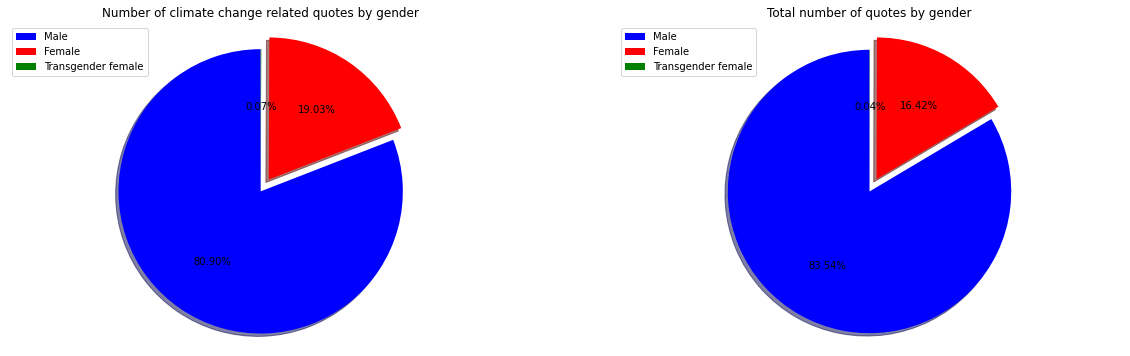

In [ ]:
# Plot info 
labels = ['Male', 'Female', 'Transgender female']
columns = ['quotation','total_num_quotes']
titles = ['Number of climate change related quotes by gender',
          'Total number of quotes by gender']

# Plot data
pie_chart(labels=labels,
          data = count_by_gender,
          titles = titles,
          columns= columns,
          colors = ['b','r','g'],
          explode = (0,0.1,0))

Although male gender has more climate change related quotes and more total number of general quotes than women, in the table we can see that ratio present us the information that female gender is more aware of this global problem. This can be interpreted as Simpson's paradox.<br>
Interesting...

NOTE: Trangender female gender does not take the significant part of the data, so we will neglect it in our observation.

### 2. Age analysis

Secondly, we will analyse data with respect to age.
Is awareness more present in certain age groups?

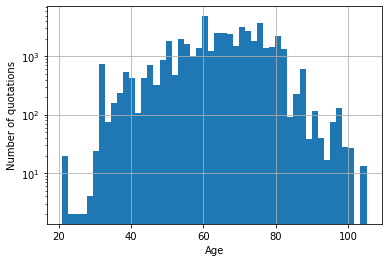

In [55]:
# Plotting number of quotes by age
df_quotes.age.hist(bins=50, log= True)
plt.xlabel('Age')
plt.ylabel('Number of quotations')
print()



So, we can see that number of quotes with respect to age parameter follows Gaussian-like distribution, with anomaly in the age group of 21. Interesting... <br>
Now, let's see if the age structure changes when we add gender dimensionality.

Mean for Male group: 63.20
Std for Male group: 13.65

Mean for Female group: 60.70
Std for Female group: 13.02

Mean for Transgender female group: 49.00
Std for Transgender female group: 17.09




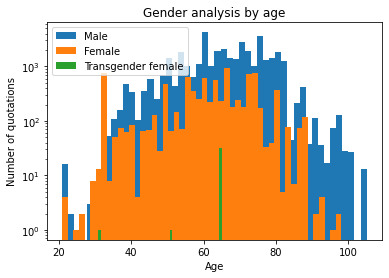

In [41]:
# Plotting distributions of quotations by gender
column = 'age'
log_flag = True
bins = 50

# Separating data by gender
for gender in info_by_speaker.gender_name.unique():
  gender_group = info_by_speaker[info_by_speaker.gender_name==gender]
  plt.hist(gender_group[column], weights = gender_group['quotation'],  label = gender, log=log_flag, bins=bins)
  print('Mean for %s group: %.2lf'% (gender,gender_group[column].mean()))
  print('Std for %s group: %.2lf\n'% (gender,gender_group[column].std()))

# Adding plot details
plt.title('Gender analysis by age')
plt.xlabel('Age')
plt.ylabel('Number of quotations')
plt.legend()
print()

The visual representatinon, as well as the mean values, are similar, we could ask ourselves if these two distributions are the same.
Since the std values are similar, we can apply ttest.

In [ ]:
# Test similarities of the distributions
males = info_by_speaker[info_by_speaker.gender_name=='Male']
females = info_by_speaker[info_by_speaker.gender_name=='Female'] 
ttest_ind(males.age.values, females.age.values)

Ttest_indResult(statistic=4.295727599853131, pvalue=1.793521363723521e-05)

Since the p-value is less than ordinary 0.01, we can conclude that difference in mean values is significant, therefore these are the different distributions.

### 3. Educational analysis

How level of education affects self-awareness?

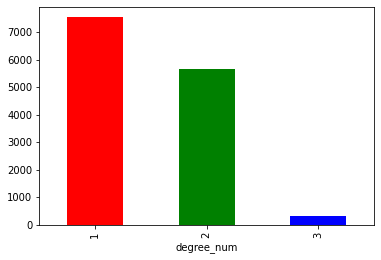

In [ ]:
# Dropping speakers without degree values
academic_speakers_data = info_by_speaker[info_by_speaker.degree_num != 0]

# Extracting and plotting number of quotes per academic degree 
colors = ['r','g', 'b']

academic_speakers_data.groupby(by='degree_num') \
                      .sum()['quotation']\
                      .plot.bar(log=False,
                                color = colors)
print()

Mean for 1 degree: 137.05455
Std for 1 degree: 400.37693
Mean for 2 degree: 226.92000
Std for 2 degree: 547.74431
Mean for 3 degree: 76.25000
Std for 3 degree: 39.21973


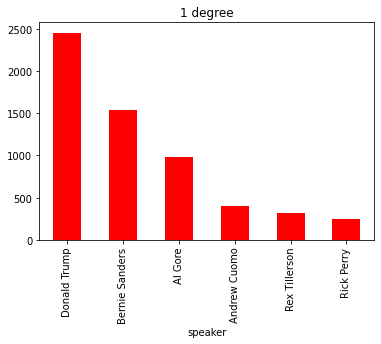

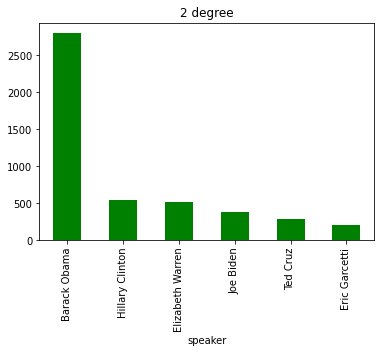

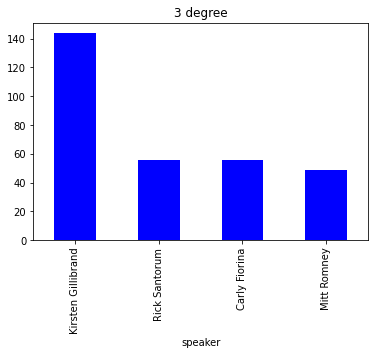

In [ ]:
# Extracting and plotting N speakers with most quotations (with respect to 
# academic degree)
N=6

# Filtering data by condition of academic degree
for degree_num in np.sort(academic_speakers_data.degree_num.unique()):

  # For each academic degree, we create independent figure
  plt.figure()

  # Extracting speakers and number of quotes with respect to degree_num
  degree = info_by_speaker[info_by_speaker.degree_num==degree_num]['quotation']


  # Crafting plot title
  title = '%d degree' % (degree_num)

  # Plotting first N speakers and number of quotes
  degree[:N].plot.bar(title= title, color = colors[degree_num-1])

  # Calculating descriptive statistics (mean and std)
  print('Mean for %d degree: %.5lf' % (degree_num, degree.values.mean()))
  print('Std for %d degree: %.5lf' % (degree_num, degree.values.std()))

### 4. Analysis with respect to political party

Does the beloning political party influences (or reflects) speaker's attitude towards climate change?

In [ ]:
# Extracting quotations by political parties
count_by_parties = info_by_speaker.groupby(by='party_name') \
                      .sum()[['quotation','total_num_quotes']] \
                      .sort_values(by='quotation',ascending= False)
# Calculating ratio
count_by_parties['ratio'] = count_by_parties.quotation *100 / count_by_parties.total_num_quotes
count_by_parties.head()

,quotation,total_num_quotes,ratio
party_name,,,
Democratic Party,31127,2514868,1.237719
Republican Party,15919,3210855,0.495787
Libertarian Party,72,8970,0.802676
Independent politician,61,6028,1.011944
Constitution Party,4,1306,0.306279


Since libertarians, constitutionalists and independent politicians present really small percent of data, we will neglect them from our analysis.

In [ ]:
# Preserving only quotes of Democrats and Republicans
count_by_parties = count_by_parties[:2]

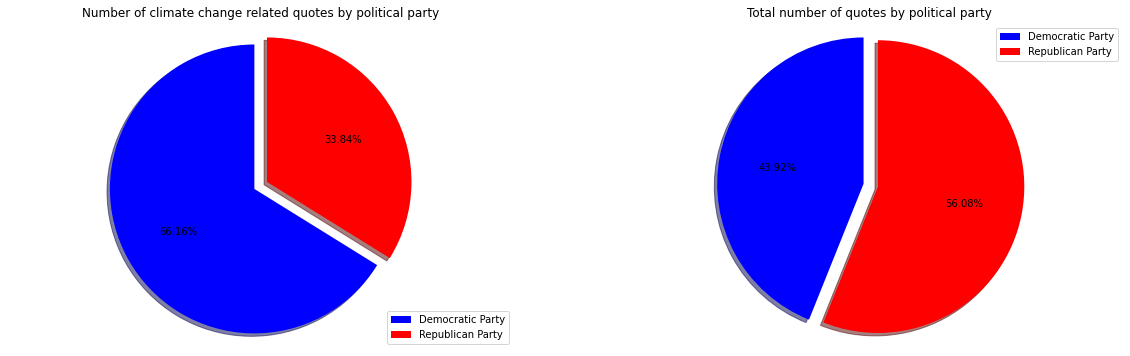

In [ ]:
# Plotting number of quotes by party

# Plot info
labels = ['Democratic Party',  'Republican Party']
columns = ['quotation','total_num_quotes']
titles = ['Number of climate change related quotes by political party',
          'Total number of quotes by political party']

# Plot data
pie_chart(labels = labels,
          data = count_by_parties,
          titles = titles,
          columns = columns,
          )

From the above inspection, we see extraordinary event.
Democratic party, although having less number of general quotes in total, has bigger number of quotes related to climate change. Does it mean that Democrats are more conscious?<br>
On the other hand, ratio values are very small, so it may lead us to believe that political affiliation is irrelevant? <br>
Peculiar...

#### 5. Sentiment and misinformation analysis

Let's observe quotes on sematnic level, but with respect to political parties:
-  Firstly, let's analyse in which atmosphere are quotes presented. <br> As you may recall, features relevant to this analysis are extracted using pretrained **DBERT** (Distiled BERT for sentiment analysis, i.e. HuggingFace implementation) model. This is described in the column 'sentimentScores'. To be more precise, this feature has values in the range [-1,1], where negative values present negative sentiment of the quote, while positive values present positive sentiment. <br> So let's dig in!

In [124]:
# Extracting relevant quotes
df_rep_dem = df_quotes[(df_quotes.party_name == 'Republican Party') | \
                       (df_quotes.party_name == 'Democratic Party')]

# Cunting total number of quotes by party
total_num = df_rep_dem.groupby('party_name').count()['quotation']
# Separating quote with respect to sentiment
positive_sentiment = df_rep_dem[df_rep_dem.sentimentScores >= 0]
negative_sentiment = df_rep_dem[df_rep_dem.sentimentScores < 0]

# Grouping data by political parties
positive_sentiment = positive_sentiment.groupby('party_name').count()['quotation'] 
negative_sentiment = negative_sentiment.groupby('party_name').count()['quotation']

# Calculating ratios
positive_sentiment_ratio = positive_sentiment / total_num
negative_sentiment_ratio = negative_sentiment / total_num

# Creating DataFrames
positive_sentiment = pd.DataFrame({'positive_number': positive_sentiment,
                                   'total_num': total_num,
                                   'ratio':positive_sentiment_ratio})
# Creating DataFrames
negative_sentiment = pd.DataFrame({'negative_number': negative_sentiment,
                                   'total_num': total_num,
                                   'ratio':negative_sentiment_ratio})


So what can we see about positive sentiment?

In [ ]:
positive_sentiment

,positive_number,total_num,ratio
party_name,,,
Democratic Party,17183,30599,0.561554
Republican Party,7199,15967,0.450867


Based on the values in the table, and on the graphical representation bellow,
we can see that Democratic Party has tendecy to cite their quotes mostly with positive sentiment. <br>

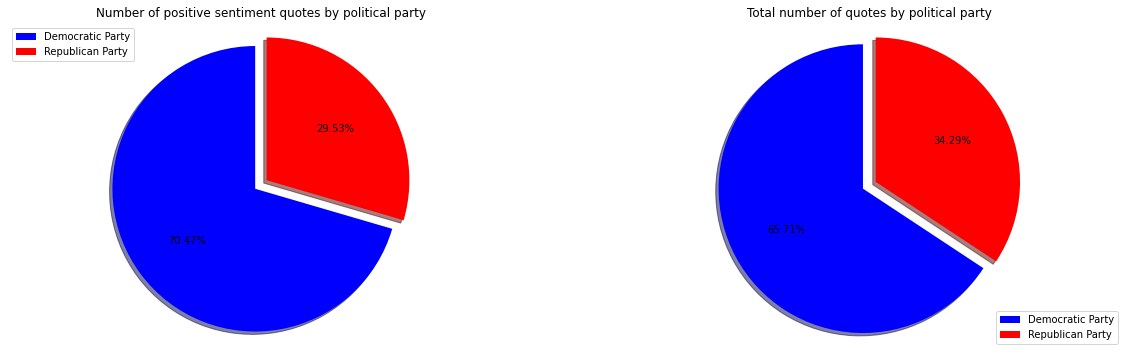

In [ ]:
# Plotting pie chart for positive sentiment analysis
# Plot info
labels = ['Democratic Party',  'Republican Party']
columns = ['positive_number','total_num']
titles = ['Number of positive sentiment quotes by political party',
          'Total number of quotes by political party']

# Plot data
pie_chart(labels = labels,
          data = positive_sentiment,
          titles = titles,
          columns = columns,
          )

But what about the negative sentiment?

In [ ]:
negative_sentiment

,negative_number,total_num,ratio
party_name,,,
Democratic Party,13416,30599,0.438446
Republican Party,8768,15967,0.549133


Based on the statistics presented in table above, and the visualization on the plots bellow, we can conclude that Republicans are more likely (explained by bigger ratio number) to cite their qotes with negative sentiment. <br>
Note also that, although Democrats have more quotes with negative sentiment, and more quotes in total, the Republicans are more likely (explained by bigger ratio number) to cite their quotes with negative sentiment. This is another example of Simpson's paradox.

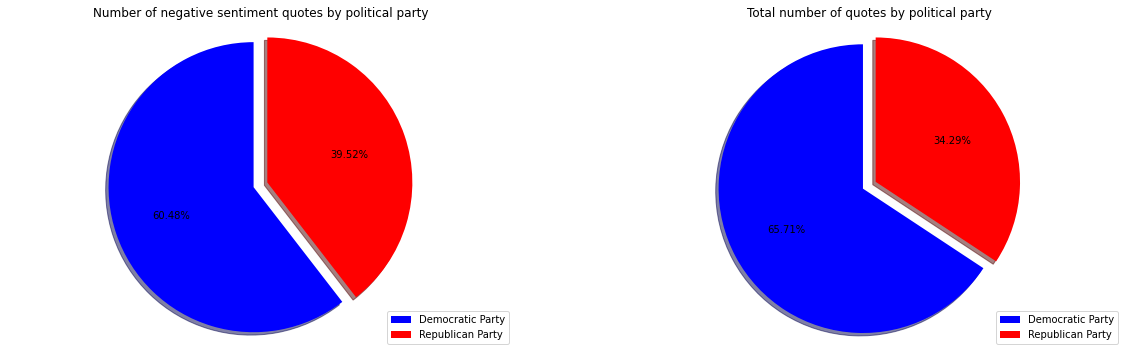

In [ ]:
# Plotting pie chart for positive sentiment analysis
# Plot info
labels = ['Democratic Party',  'Republican Party']
columns = ['negative_number','total_num']
titles = ['Number of negative sentiment quotes by political party',
          'Total number of quotes by political party']

# Plot data
pie_chart(labels = labels,
          data = negative_sentiment,
          titles = titles,
          columns = columns,
          )

2. Secondly, we will analyse misinformations related with climate change quotes.
As you may recall, the relevant feature is described in the column *'cardsPredLabel'*.
This feature has been extracted using CARDS (Computer-assisted detection and classification of misinformation about climate change) model. This feature has integer values from the range [0,17]. The value 0 refers to quote not being classified as misinformation, while integer values from rage [1-17] refer to different classes of misinformations. For our analysis, we will focus only on question if misinformation exists, and, therefore, we will consider only 2 classes: true quote (i.e. value of 0) and misinformation (i.e. any integer value from range [1-17].<br>
So let's start.

In [ ]:
# Converting feature cardsPredLabel from range [0-17] to indicator value 
# i.e. the indicator if the quote is misinformation or not
df_rep_dem['is_misinformation'] = df_rep_dem.cardsPredLabel != 0

# Calculating statistics with regard to political party
misinformations =  df_rep_dem[df_rep_dem.is_misinformation].groupby('party_name').count()['quotation']
true_quotes =  df_rep_dem[~df_rep_dem.is_misinformation].groupby('party_name').count()['quotation']

# Adding total_num feature 
misinformations = pd.DataFrame({'misinformations': misinformations,
                                   'total_num': total_num})
true_quotes = pd.DataFrame({'true_quotes': true_quotes,
                                   'total_num': total_num
                                   })

# Calculating ratios
misinformations['ratio'] = misinformations.misinformations / misinformations.total_num
true_quotes['ratio'] = true_quotes.true_quotes / true_quotes.total_num


Similarly to sentiment analysis, firstly let's analyse positive, or in this case true quotes.

In [ ]:
true_quotes

,true_quotes,total_num,ratio
party_name,,,
Democratic Party,29448,30599,0.962384
Republican Party,13977,15967,0.875368


In the table we can see that Democrats are dominant over Republicans in every aspect.
Based on the values presented in the table, we can see that Democrats are more likely to say true quotes, i.e. quotes which are not misconseption on the topic of climate change.
<br>
And what about misconseptions?

In [ ]:
misinformations

,misinformations,total_num,ratio
party_name,,,
Democratic Party,1151,30599,0.037616
Republican Party,1990,15967,0.124632


Interesting. Here we can see that Republicas are more likely to say deceiving quotes, or fake-news. 
<br>

So far, regarding sophisticated sentiment analysis, we have noticed that Republicans are more negative and more deceiving. <br> Not a lovely characteristics.

But wait! Do those sentiment truly describe the politicians attitude? Does the broadcasting services (i.e. media) provides influence also?

Let's analyse media-dimension of sentimet:

In [ ]:
# Extracting the broadcasting services from array-type column

# Removing duplicates if any
df_rep_dem.domains = df_rep_dem.domains.apply(np.unique)

# Exploding dataset, so that for each domain (media) in list, we have one entry in DataFrame
exploded = df_rep_dem.explode(column = 'domains')

# Separating data with respect to political party
dem  = exploded[exploded.party_name == 'Democratic Party']
rep  = exploded[exploded.party_name == 'Republican Party']

# Grouping data by media, and calculating statistics
dem  = dem.groupby('domains').agg({'sentimentScores': 'mean', 'is_misinformation': 'mean', 'quotation': 'count'})
rep  = rep.groupby('domains').agg({'sentimentScores': 'mean', 'is_misinformation': 'mean', 'quotation': 'count'})

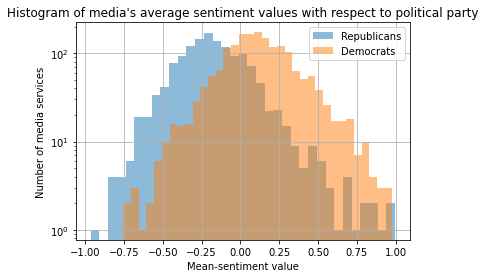

In [132]:
# Plotting mean sentiment value of media's quotes with respect to political parties
rep.sentimentScores.hist( bins = 35, log= True, label = 'Republicans', alpha = 0.5)
dem.sentimentScores.hist( bins = 35, log= True, label = 'Democrats', alpha = 0.5)
plt.title('Histogram of media\'s average sentiment values with respect to political party')
plt.xlabel('Mean-sentiment value')
plt.ylabel('Number of media services')
plt.legend()

From the plot above, we can conclude that the climate change relate quotes said by Democrats are more likely to be presented by media in positive atmosphere, while the climate change relate quotes said by Republicans are more likely to negatively broadcasted. We can see a little bit of polarisation od the media, so we may conclude that overall sentiment of quote, in addition to speaker-related, contains media-related component as well.

So what about misconseptions?

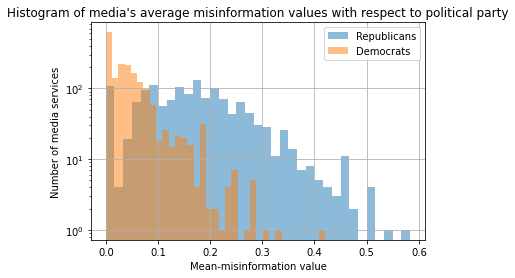

In [133]:
# Plotting mean value of media's misinformation characteristics with respect to political parties
rep.is_misinformation.hist( bins = 35, log= True, label = 'Republicans', alpha = 0.5)
dem.is_misinformation.hist( bins = 35, log= True, label = 'Democrats', alpha = 0.5)
plt.title('Histogram of media\'s average misinformation values with respect to political party')
plt.xlabel('Mean-misinformation value')
plt.ylabel('Number of media services')
plt.legend()

Similarly to previous conclusion, we can see that there is polarization in this context also. Since Republican's quotes, comparing to Democrat's quotes, are more likely to be broadcasted as misinformation, we may also conclude that overall degree of misinformation contains speaker-related and media-related aspects. <br>
Since we are not able to determin which of the components, i.e. speaker-related or media-related, is prevailing, we cannot make conclusions regarding sentiment/misinformation part of quotes with respect to political parties.

### 6. Quantitative analysis on individual politicians

The aforemetioned analysis is with respect to political party as a collective.
But what about the individuals from those parties?
Let's observe the most talkative ones.

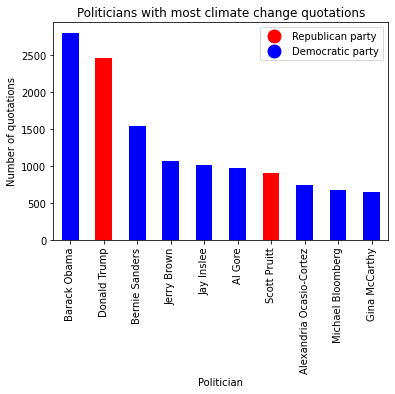

In [ ]:
# Plotting first N speakers with most quotations
N=10

# Crafting colors for different parties
COLORS = {'Republican Party' :'red', 
           'Democratic Party' : 'blue'}
colors = info_by_speaker[:N].party_name.apply(lambda party: COLORS[party])

# Plotting first N speakers with most quotations, colored by political party
ax = info_by_speaker[:N].quotation.plot.bar(
                      title = 'Politicians with most climate change quotations',
                      ylabel = 'Number of quotations',
                      xlabel = 'Politician',
                      color= colors)

# Crafting legend for plot
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label='Republican party',
                          markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='o', color='w',
                          label='Democratic party',
                          markerfacecolor='blue', markersize=15)
                  ]
ax.legend(handles=legend_elements)
print()

We can notice here some very important figures of USA political life: Barack Obama, Donald Trump, etc. In addition, through these top 10 speakers, we can induce characteristics which are probably important in soving our problem. Those characteristics are: president, congress memeber, was presidental candidate during his career.

Okay, that's enough of analysing the isolated parameters.
We have observed some interesting statistics, but is it relevant to our problem? <br>
Recall that our analysis should be based on different political and demographic parameters of speakers. So, let's see which of aforementioned and described parameters really matter. <br>
As Bob West would say, 'Linear regression gives us free p-values'. So why would not we utilize this present.

### 7. Regression analysis

Since we are using linear regresion for the purpose of descriptive analysis, we do not have to split data into train/test subsets. <br>
Let's dig in...

NOTE: Again, we are interested only in the quotes of Democrats and Republicans

In [9]:
# Extracting relevant columns
columns =  ['degree_num', 'age', 'party_name', 'gender_name', 'was_candidate',
            'was_in_congres', 'party_count', 'quotation', 'was_president',
            'numOccurrences', 'totalNumOccurrences','total_num_quotes']

# Preserving only quotes of Democrats and Republicans
regression_data = info_by_speaker[(info_by_speaker.party_name == 'Democratic Party')| \
                      (info_by_speaker.party_name == 'Republican Party')][columns]
regression_data.head()

,degree_num,age,party_name,gender_name,was_candidate,was_in_congres,party_count,quotation,was_president,numOccurrences,totalNumOccurrences,total_num_quotes
speaker,,,,,,,,,,,,
Barack Obama,2,60,Democratic Party,Male,True,True,1,2801,True,19372,358404,83105
Donald Trump,1,75,Republican Party,Male,True,False,5,2459,True,21832,313392,675898
Bernie Sanders,1,80,Democratic Party,Male,False,True,5,1540,False,5636,56333,67834
Jerry Brown,0,83,Democratic Party,Male,False,False,1,1070,False,7386,16402,12443
Jay Inslee,0,70,Democratic Party,Male,False,True,1,1016,False,4990,4401,10727


Now when we have extracted relevant columns, let's extract features and outcomes. <br>
We want to see how much of an impact the given parameters have on the number of climate change related qutoes said by the speaker. So, our outcome will be number of climate change realted quotes, and, therefore, features will be all other columns specified in the cell above.

In [10]:
# Extract features
# Features array
features =  ['degree_num', 'age', 'party_name', 'gender_name', 
             'was_candidate', 'was_in_congres', 'party_count', 'was_president',
             'numOccurrences', 'totalNumOccurrences','total_num_quotes']
# Fit and summarize OLS model.
formula = 'quotation ~ ' + '+'.join(features)
mod = smf.ols(formula= formula, data = regression_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              quotation   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4929.
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:54:01   Log-Likelihood:                -13979.
No. Observations:                3167   AIC:                         2.798e+04
Df Residuals:                    3154   BIC:                         2.806e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Wow, look at these. <br>
Based on the result we can conclude:
- Features *age* and *gender* have p-values bigger than 0.05, and therefore do not have significant influence on outcome, i.e. on the number of quotations regarding climate change. <br>
- Political features (*was_candidate, was_in_congres, was_president, party_count, party_name*) have significant impact on outcome.
- Feature *degree_num* have significant impact on outcome.
- Features *numOccurrences, totalNumOccurrences, total_num_quotes*, which are more media related, have significant impact on outcome.

Note the R<sup>2</sup> coefficient, it is 0.949, which means that we have explained most of the variance. But this observation is not of a importance if residuals are not zero-centered. Let's check that.


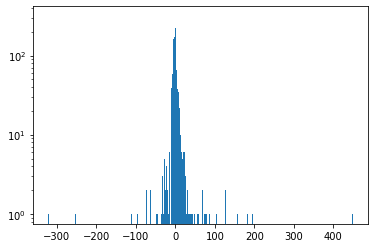

In [11]:
predictions = res.predict(regression_data[features])
residuals = regression_data.quotation - predictions
plt.hist(residuals.values, bins = 1000, log=True)
print()

Since residuals are zero centered, we can conclude that R<sup>2</sup> measure is relevant. <br>

### 8. Timeline analysis

Another interesting question we wanted to give answer to is which politicians are prone to fast forget issues related to our topic. <br> For this type of analysis, we will consider only politicians with most quotes about climate change (Barack Obama, Bernie Sanders, Donald Trump, etc.), since they are the most representative individuals.

Firtsly, let's consider former presidents, Barack Obama and Donald Trump.

In [8]:
# Adding feature of total number of general quotes by months of speaker
# This is reflected in column 'num_of_quotes'
df_added_total_num = pd.merge(left= df_quotes, left_on=['qids','date'], right = df_counts, right_on=['qids','date'])

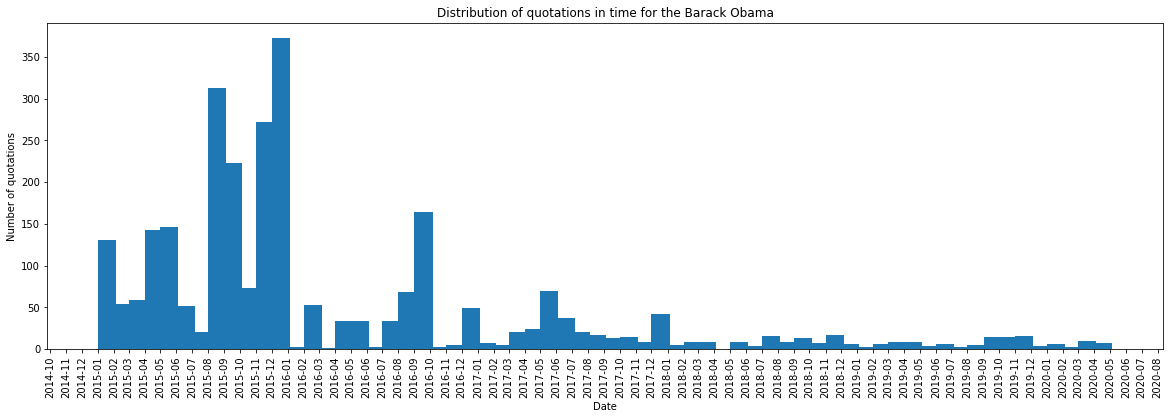

In [11]:
quotes = timeline_analysis_for_politician('Barack Obama',  bins = 50 ,sentiment_analysis=False, data = df_added_total_num)

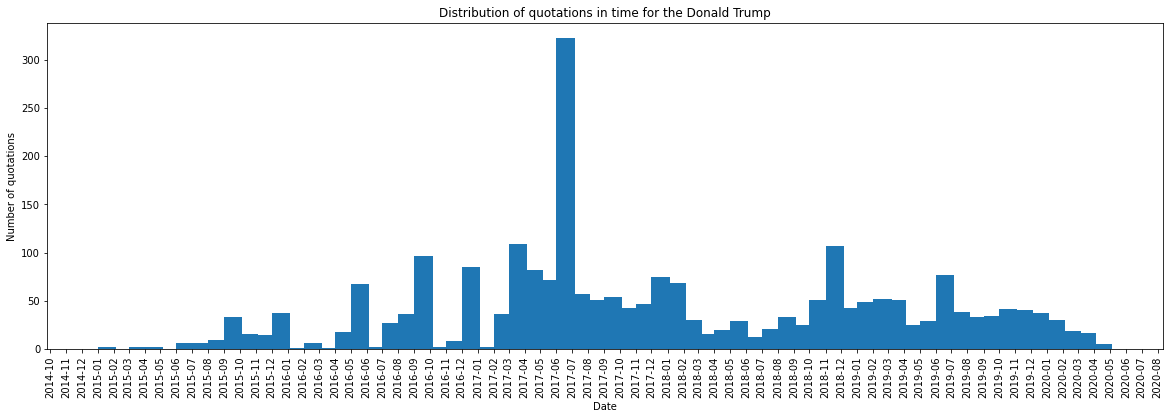

In [15]:
quotes = timeline_analysis_for_politician('Donald Trump',  bins = 50 ,sentiment_analysis=False, data = df_added_total_num)

Note another interesting thing here. Note that Barack Obama said the most of his climate change related quotes in the period before the year 2017, while Donald Trump became more cited in the year 2017 and onwards. As you probably know, 2016-2017 is the period of changes in which Barack Obama finished his carrer as US president, and Donald Trump began his. Could this be a confounder, i.e. Barack Obama did not forget about the climate change issues, rather he became irrelevant after the end of his career (and vice-versa for Donald Trump)? Recall that in linear regression analysis, we noted importance of media relevat features. <br>

Let's take another speakers, important figures but who were not elected as US presidents during their careers. Ideal one are Bernie Sanders and Hillary Clinton.

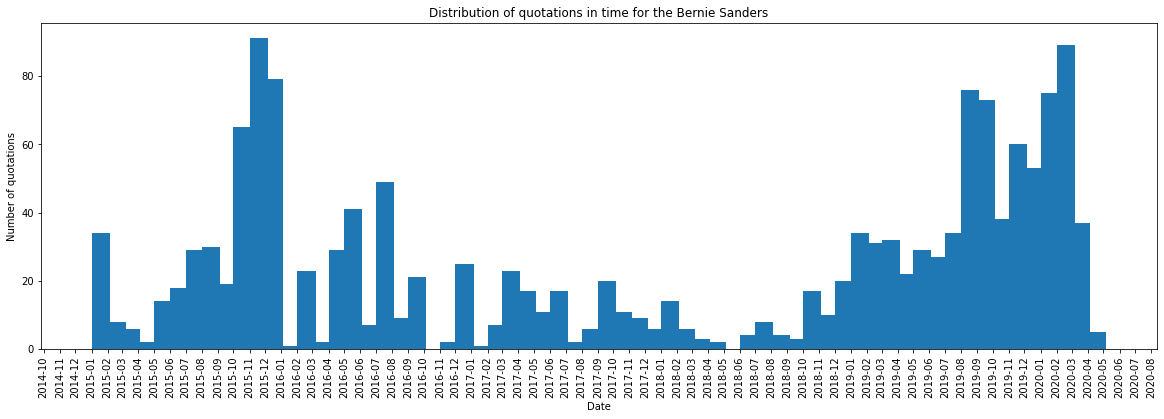

In [17]:
quotes = timeline_analysis_for_politician('Bernie Sanders',bins = 50 ,sentiment_analysis=False, log_flag=False, data = df_added_total_num)

Bernie Sanders mostly talked about issue of climate change in two periods: end of the year 2015 and end of the year 2019. Those are the periods of his presidential campaigns. But did he magically become more aware of climate change problems during this periods? Or is there another explanation? <br>
Let's see the situation in case of Hillary Clinton.

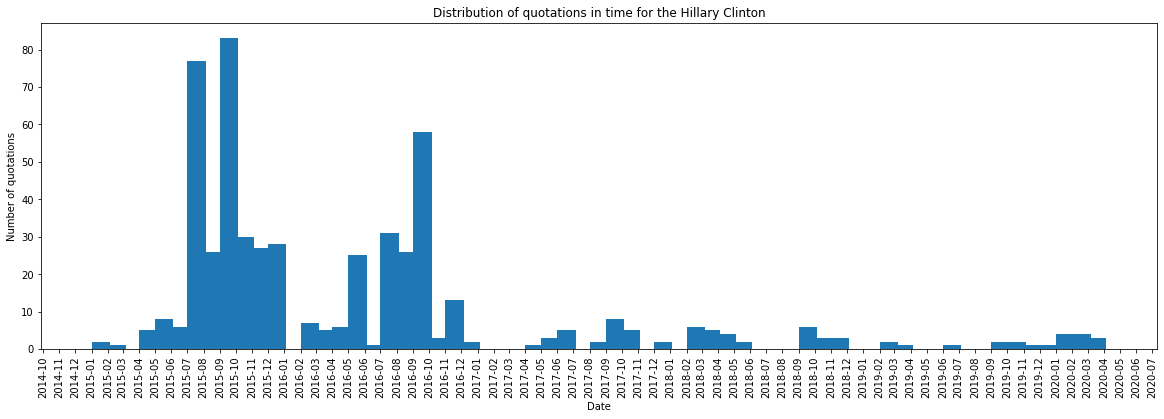

In [ ]:
quotes = timeline_analysis_for_politician('Hillary Clinton',bins = 50 , sentiment_analysis=False, log_flag=False, data = df_added_total_num)

Interesting, trend of awareness of climate change problems is also emphasized here in the period of political campaigns.



So, now we became more suspicious in the fact that politicians abuse this global issue, so they could gain on a popularity needed in the elections process.


Our assumption is that during the period of the political campaigns (treatment), politicians rise awareness of climate change issue, i.e. they have more quotes regarding climate change (outcome).

How could we test this? Well, simply we will observe number of quotes speaker had in the periods of time when campaings were active and inactive. In order to solve the problem of potential confounder, we will have to perform matching.
And, this is the most interesting part, we will match speaker with...himself! Perfect match! <br> So, we will observe how many quotes speaker had in period without campaigns (i.e. without treatment), and in the period of campaings (i.e. with treatment). 

Based on the informations provided in the [article](https://www.thoughtco.com/when-the-race-for-president-begins-3367552), we will use as campaing period the period of year and a half before the elections.

In [135]:
# Note that for the end of the period, we will add more days, because tensions are visible even weeks after the elections
# and, therefore, quotes during the tension-period should also be considered as treated
PERIOD_1 = [datetime.date(2015, 4, 1) , datetime.date(2016, 12, 1)]
PERIOD_2 = [datetime.date(2019, 4, 1),  datetime.date(2020, 12, 1)]


# Add indicator if quote was said during the campaign period
df_quotes['treated'] = df_quotes.date.apply(lambda date_: (PERIOD_1[0] <= date_ <= PERIOD_1[1]) | (PERIOD_2[0] <= date_ <= PERIOD_2[1]))

# Separate data by treatment indicator
treated = df_quotes[df_quotes.treated].groupby('qids').count()['quotation']
control = df_quotes[~df_quotes.treated].groupby('qids').count()['quotation']

# Perform matching
matched = pd.DataFrame({'treated': treated, 'control':control})
matched

,treated,control
Q1026119,1.0,NaN
Q1027026,5.0,2.0
Q1027431,6.0,7.0
Q1029527,2.0,4.0
Q10327963,2.0,2.0
...,...,...
Q984010,9.0,3.0
Q984183,6.0,NaN
Q984205,8.0,12.0
Q984509,3.0,5.0


But note that some of the speaker are not matched, i.e. they did not have any climate change related quote in one of the groups (treated or control).
Let's filter them out, and look at the distributions.

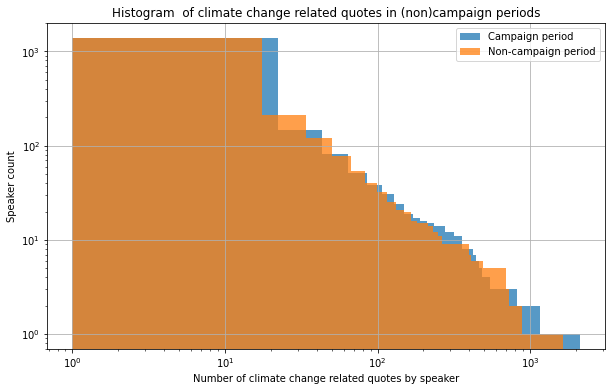

In [137]:
# Filtering unmatched
matched = matched.dropna()

# Histrograms
fig = plt.figure(figsize = (10,6))
matched.treated.hist(bins = 100, label = 'Campaign period', alpha = 0.75, cumulative=-1)
matched.control.hist(bins = 100, label = 'Non-campaign period', alpha = 0.75, cumulative=-1)
plt.xlabel('Number of climate change related quotes by speaker')
plt.ylabel('Speaker count')
plt.title('Histogram  of climate change related quotes in (non)campaign periods')
plt.loglog(True)
plt.legend()
print()

Since this CCDF graph is close to linear on loglog scale, we can conclude that underlying distributioin is sort of a power-law. <br>
We can see that distribution of the treated group is slightly shifted, so it could express a tendency in quoting climate change issues during the period of political campaigns. <br>
But is it common to all politicians, or only specific for some political parties? Let's test it with respect to political party.

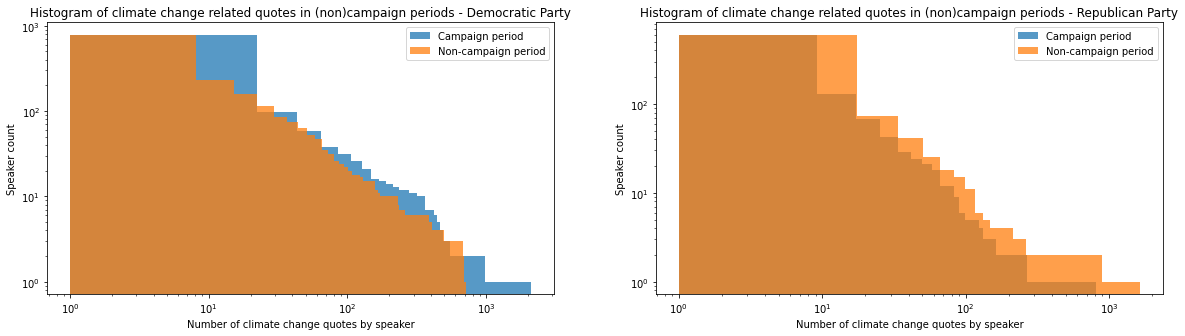

In [138]:
fig, ax = plt.subplots(1,2, figsize= (20,5))
party = ['Democratic Party', 'Republican Party']
for i in range(2) :
  # Extract quotes for party
  df_party = df_quotes[df_quotes.party_name==party[i]]

  # Separate data by treatment indicator
  treated_party = df_party[df_party.treated].groupby('qids').count()['quotation']
  control_party = df_party[~df_party.treated].groupby('qids').count()['quotation']

  # Perform matching
  matched = pd.DataFrame({'treated': treated_party, 'control':control_party})

  # Filtering unmatched
  matched = matched.dropna()

  # Histrograms
  ax[i].hist(matched.treated, label = 'Campaign period', bins = 100,  alpha = 0.75, cumulative=-1)
  ax[i].hist(matched.control, label = 'Non-campaign period', bins = 100,  alpha = 0.75, cumulative=-1)
  # matched.control.hist(bins = 100, label = 'Control', alpha = 0.75, cumulative=-1)
  ax[i].set_xlabel('Number of climate change quotes by speaker')
  ax[i].set_ylabel('Speaker count')
  ax[i].set_title('Histogram of climate change related quotes in (non)campaign periods - %s'%party[i])
  ax[i].loglog(True)
  ax[i].legend()
  print()

Wow, interesting.
So, Democrats are more prone to inhance usage of climate change topic in their political campaigns. Shifty, shifty...

# 4. Helper functions

In [9]:
# Plotting number of quotes by party
# Pie chart
def pie_chart(labels , titles, data, columns, explode= (0, 0.1), colors = ['b','r']):
  '''
  Plots pie chart on gived data.

  Parameters
  ----------
  labels : array-like structure of labels
  values : array-like structure of values
  ax1 : subplot
  explode : graphical parameter for exploding the pie chart
  titles : array-like structure of plot titles
  data: pd.DataFrame
  colors : array-like structure of color names
  columns: array-like structure of column names

  Returns
  -------
  None
  '''
  fig1, ax1 = plt.subplots(1,len(titles),figsize=(20,6))
  # Plotting data
  
  for i in range(len(titles)):
    values=data[columns[i]]
    sizes = values *100 / values.sum()
    ax1[i].pie(sizes, 
            explode=explode,
            labels=None,
            autopct='%1.2f%%',
            colors=colors,
            shadow=True,
            startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1[i].axis('equal') 
    ax1[i].legend(labels=labels, loc='best')
    ax1[i].title.set_text(titles[i])
    print()

In [10]:
def timeline_analysis_for_politician(name, log_flag = False, bins= 40,sentiment_analysis= 1, ratio_flag = False , bymonth=(1,2,3,4,5,6,7,8,9,10,11,12), data=df_quotes):
    '''
    Extracts quotes from given speaker, and plots distribution
    with respect to quotation's time

    Parameters
    ----------
    name: String
      Name of the speaker
    log_flag: boolean
      Idicator if plot should be log
    axes_modifier: int
      Number of bins

    Returns
    -------
    pd.DataFrame
      Extracted quotations of given speaker
      
    '''

    # Extracting politician's quotes
    quotes = data[data.speaker == name]

    # Creating title for the plot
    title = 'Distribution of quotations in time for the %s' % name

    # Creating x-axis
    
    date_ticks = quotes.date.sort_values().unique()
    mpl_data = mdates.date2num(date_ticks)

    # Plotting timeline histogram of his quotations
    fig, ax = plt.subplots(1,1, figsize = (20,6))

    ylabel='Number of quotations'
    cnt_by_date= quotes

    if sentiment_analysis == 1:

      positive_quotes = quotes[quotes.sentimentScores >= 0]
      negative_quotes = quotes[quotes.sentimentScores < 0]

      positive_percentage = positive_quotes.shape[0] * 100 / quotes.shape[0]
      negative_percentage = negative_quotes.shape[0] * 100 / quotes.shape[0]
      labels =  ['Positive quotes: %.2lf%%' % positive_percentage , 'Negative quotes: %.2lf%%' % negative_percentage]
      ax.hist([positive_quotes.date, negative_quotes.date], bins= bins, log=log_flag, label=labels, stacked=True)
      plt.legend()

    elif sentiment_analysis == 2:
      misinformations = quotes[quotes.cardsPredLabel > 0]
      truth_informations = quotes[quotes.cardsPredLabel == 0]

      misinformations_percentage = misinformations.shape[0] * 100 / quotes.shape[0]
      truth_informations_percentage = truth_informations.shape[0] * 100 / quotes.shape[0]
      labels =  ['True quotes: %.2lf%%' % truth_informations_percentage , 'Misinformation quotes: %.2lf%%' % misinformations_percentage]
      ax.hist([truth_informations.date, misinformations.date], bins= bins, log=log_flag, label=labels, stacked=True)
      plt.legend()

    else :
      # Calculate number of climate change quotes by dates
      cnt_by_date = quotes.groupby(by='date').agg({'quotation': 'count',
                                                    'num_of_quotes' : 'first'
                                                  })  
      

      # Calculate frequency of climate change quotes by dates
      if ratio_flag:      
        cnt_by_date.quotation =cnt_by_date.quotation *100 / cnt_by_date.num_of_quotes 
        ylabel='Percent of climate change related quotations'

      # Plot 
      ax.bar( cnt_by_date.index, cnt_by_date.quotation.values,
            width = 35,
            log= log_flag,
            align = 'edge')
    
    locator = mdates.MonthLocator(bymonth=bymonth)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Date')
    return cnt_by_date